# CMS GIWAXS mask & .poni generation notebook

In [1]:
# Kernel updates if needed, remember to restart the kernel after running this cell!:
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory

Obtaining file:///nsls2/users/alevin/repos/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0+untagged.557.ga1d7189-0.editable-py3-none-any.whl size=5436 sha256=07f3e3b56740813f123414d455c8cc619a6fac10bde62f8e8be56e726068a25a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tfpgcy18/wheels/7d/89/c7/db1d0cb1cf714f3a03a438abee7b78ce09921efd15259b1f5f
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0+untagged.556.g222b349
    Uninstalling PyHyperScattering-0+untagged.556.g222b349:
      Successfully uninstalled PyHyperScattering-0+untagged.556.g222b349


## Imports

In [1]:
# Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import PyHyperScattering as phs
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration
import pygix

print(f'Using PyHyperScattering Version: {phs.__version__}')
print(f"Using pyFAI version {pyFAI.version}")

# Initialize a giwaxs data loader without any metadata naming scheme
loader = phs.load.CMSGIWAXSLoader()

/nsls2/users/alevin/repos/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


Using PyHyperScattering Version: 0+untagged.557.ga1d7189
Using pyFAI version 2023.5.0


## Define paths & show calibration file

In [10]:
calibPath.absolute()

PosixPath('/nsls2/data/cms/proposals/2023-2/pass-311415/KWhite5/maxs/raw/LaB6_5.6m_12.7keV_4250.1s_x0.001_th0.120_10.00s_1118442_maxs.tiff')

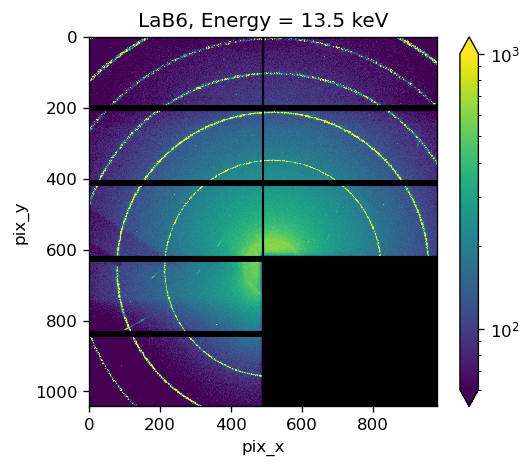

In [2]:
# Define paths
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')
dataPath = propPath.joinpath('KWhite5')
calibPath = dataPath.joinpath('maxs/raw/LaB6_5.6m_12.7keV_4250.1s_x0.001_th0.120_10.00s_1118442_maxs.tiff')
maskponiPath = userPath.joinpath('giwaxs_suite/beamline_data/maskponi')  # place for pyhyper-drawn masks and poni files

# Load calibration file
LaB6_DA = loader.loadSingleImage(calibPath)  # Loads the file specified at calibPath into an xr.DataArray object
energy = 13.5  # keV

# Plot 
cmap = plt.cm.viridis.copy()  # Set a colormap, here I've chosen viridis
cmap.set_bad('black')  # Set the color for the detector gaps
clim=(6e1, 1e3)  # Specify color limits

ax = LaB6_DA.plot.imshow(norm=LogNorm(clim[0], clim[1]), cmap=cmap, figsize=(5,4), origin='upper')
ax.axes.set(aspect='equal', title=f"LaB6, Energy = {energy} keV")
ax.figure.set(dpi=120)
plt.show()

## Draw mask:

In [4]:
# Draw mask
draw = phs.IntegrationUtils.DrawMask(LaB6_DA, clim=clim)
# draw.ui()

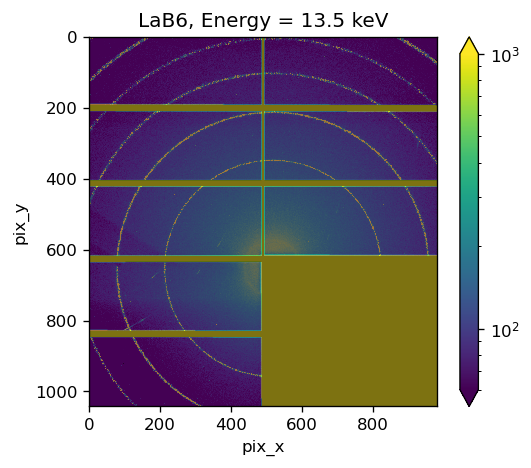

In [6]:
# Save drawn mask above
# draw.save(maskponiPath.joinpath('LaB6.json'))
draw.load(maskponiPath.joinpath('LaB6.json'))
mask = draw.mask  # Loads mask as numpy array

# Plot it over calibrant image to check
ax = LaB6_DA.plot.imshow(norm=LogNorm(clim[0], clim[1]), cmap=cmap, figsize=(5,4), origin='upper')
ax.axes.imshow(mask, alpha=0.5)
ax.axes.set(aspect='equal', title=f"LaB6, Energy = {energy} keV")
ax.figure.set(dpi=120)
plt.show()

In [8]:
transformer = phs.GIWAXS.Transform()

Init signature:
phs.GIWAXS.Transform(
    poniPath: Union[str, pathlib.Path],
    maskPath: Union[str, pathlib.Path, numpy.ndarray],
    inplane_config: str = 'q_xy',
    energy: float = None,
)
Source:        
class Transform:
    """ Class for transforming GIWAXS data into different formats. """
    def __init__(self, 
                 poniPath: Union[str, pathlib.Path], 
                 maskPath: Union[str, pathlib.Path, np.ndarray], 
                 inplane_config: str = 'q_xy', 
                 energy: float = None):
        """
        Attributes:
        poniPath (pathlib Path or str): Path to .poni file for converting to q-space 
                                        & applying missing wedge correction
        maskPath (pathlib Path or str or np.array): Path to the mask file to use 
                                for the conversion, or a numpy array
        inplane_config (str): The configuration of the inplane. Default is 'q_xy'.
        energy (optional, float): Set ene

## Run pyFAI calibration:

In [11]:
a = np.arange(0,10)
type(a)

numpy.ndarray

In [14]:
%load_ext autoreload
%autoreload

In [12]:
isinstance(a, np.ndarray)

True

### PyFAI calibration widget

In [4]:
# Set matplotlib backend to 'widget':
%matplotlib widget

In [5]:
# Open & run calibration widget
plt.close('all')
LaB6_da = loader.loadSingleImage(calibPath)  # This is needed if you did not execute the above cells for masking
wavelength = np.round((4.1357e-15*2.99792458e8)/(energy*1000), 13)  # Important to be correct! Make sure the energy is in keV and correct!
pilatus = pyFAI.detector_factory('Pilatus1M')
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = wavelength

calib = Calibration(LaB6_da.data, calibrant=LaB6, wavelength=wavelength, detector=pilatus)

### Modifying & saving poni

In [ ]:
### Check & save .poni
gr = calib.geoRef
print(gr)
print(calib.fixed)
print(gr.chi2())
# gr.save(maskponiPath.joinpath('LaB6_unfixed_rot_2023-07-15.poni'))

In [ ]:
# Optional fit with rotations fixed to 0
# Likely the best fit for transmission geometry
gr = calib.geoRef
gr.rot1=gr.rot2=gr.rot3=0
# # gr.center_array=[517, 654.47]
center_x = 517.2
# center_y = 654
gr.poni2 = center_x * gr.pixel1
# gr.poni1 = center_y * gr.pixel1
# gr.set_dist = 2.837
gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3', 'poni2'])
# gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3'])
print(gr.chi2())
print(gr)
gr.save(maskponiPath.joinpath(f'LaB6_fixed_rot_x{center_x}.poni'))

### Calibrant check

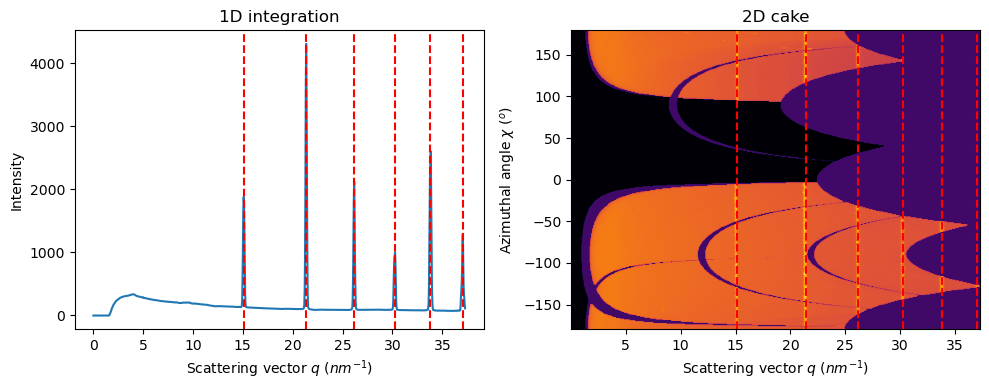

In [6]:
# Turn matplotlib backend back to inline mode & clear open widget plots
%matplotlib inline  
plt.close('all')

# This verifies that the calibration is good (overlays expected calibrant peaks with reduced data)
# azimuthal integrator tool in pyFAI for transmission mode (use pygix for GI geometry)
ai = pyFAI.load(str(maskponiPath.joinpath('LaB6_fixed_rot.poni')))  # Load the .poni calibration file into azimuthal integrator
res1 = ai.integrate1d(LaB6_da.data, 1000)  # Circular integration
res2 = ai.integrate2d(LaB6_da.data, 1000)  # Makes caked 2d image (q vs chi)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set(size_inches=(10,4))
jupyter.plot1d(res1, ax=ax1, calibrant=LaB6)
jupyter.plot2d(res2, ax=ax2, calibrant=LaB6)
ax2.set_title('2D cake')
plt.tight_layout()
plt.show()